In [ ]:
! pip install stable-baselines3[extra]
! pip install gymnasium[all]

  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 15.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl.metadata (558 bytes)
  Using cached ale_py-0.8.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 14.7 MB/s eta 0:00:00
Using cached ale_py-0.8.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.7 MB)
Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446661 sha256=b0e1ca43d5be025138937e531eb0c4f2f27e2a55457df32fb2525c972dd6fb30
  Stored in directory: /root/.cache/pip/whe

In [ ]:
# Import Helpers
from typing import Any

import numpy as np
import random
import os
import pandas as pd
from google.colab import drive

# from google.colab import files
# uploaded = files.upload()
# Import Gymnasium stuff
import gymnasium as gym
from gymnasium import Env
from gymnasium.core import ObsType
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete

# Import Stable Baseline stuff
# from stable_baselines3 import TD3, PPO, SAC
# from stable_baselines3.common.vec_env import DummyVecEnv
# from stable_baselines3.common.evaluation import evaluate_policy
# from stable_baselines3.common.env_checker import check_env
# from stable_baselines3.common.results_plotter import load_results, ts2xy
# from stable_baselines3.common.callbacks import CheckpointCallback
# from stable_baselines3.common.evaluation import evaluate_policy
# from stable_baselines3.common.env_checker import check_env
# from stable_baselines3.common.monitor import Monitor


Saving rl_utils.py to rl_utils.py


In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import collections
import random

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):
        return len(self.buffer)

def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

def train_on_policy_agent(env, agent, num_episodes):
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done, _ = env.step(action)
                    transition_dict['states'].append(state)
                    transition_dict['actions'].append(action)
                    transition_dict['next_states'].append(next_state)
                    transition_dict['rewards'].append(reward)
                    transition_dict['dones'].append(done)
                    state = next_state
                    episode_return += reward
                return_list.append(episode_return)
                agent.update(transition_dict)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list

def train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size):
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done, _ = env.step(action)
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r, 'dones': b_d}
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list


def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)

# Methodology
## Action
lever postion [-1,1]

## Observation

1.   Position
2.   Running time left
3.   Current Velocity
4.   Speed reference
5.   Next speed reference
6.   Distance to the next speed reference
7.   Train's acceleration of last time step


## Reward

1.   speed ref reward
2.   penalty according to the distance to the target (remain or beyond)
3.   -1 overspeed
4.   big reward for punctuality
5.   The end of running time, speed 0  distance 0

# SAC

In [ ]:
import random
import gym
import numpy as np
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
import rl_utils

class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        dist = Normal(mu, std)
        normal_sample = dist.rsample()  # rsample()是重参数化采样
        log_prob = dist.log_prob(normal_sample)
        action = torch.tanh(normal_sample)
        # 计算tanh_normal分布的对数概率密度
        log_prob = log_prob - torch.log(1 - torch.tanh(action).pow(2) + 1e-7)
        action = action * self.action_bound
        return action, log_prob


class QValueNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)


class SACContinuous:
    ''' 处理连续动作的SAC算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound,
                 actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma,
                 device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim,
                                         action_bound).to(device)  # 策略网络
        self.critic_1 = QValueNetContinuous(state_dim, hidden_dim,
                                            action_dim).to(device)  # 第一个Q网络
        self.critic_2 = QValueNetContinuous(state_dim, hidden_dim,
                                            action_dim).to(device)  # 第二个Q网络
        self.target_critic_1 = QValueNetContinuous(state_dim,
                                                   hidden_dim, action_dim).to(
                                                       device)  # 第一个目标Q网络
        self.target_critic_2 = QValueNetContinuous(state_dim,
                                                   hidden_dim, action_dim).to(
                                                       device)  # 第二个目标Q网络
        # 令目标Q网络的初始参数和Q网络一样
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(),
                                                   lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(),
                                                   lr=critic_lr)
        # 使用alpha的log值,可以使训练结果比较稳定
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True  # 可以对alpha求梯度
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha],
                                                    lr=alpha_lr)
        self.target_entropy = target_entropy  # 目标熵的大小
        self.gamma = gamma
        self.tau = tau
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state)[0]
        return [action.item()]

    def calc_target(self, rewards, next_states, dones):  # 计算目标Q值
        next_actions, log_prob = self.actor(next_states)
        entropy = -log_prob
        q1_value = self.target_critic_1(next_states, next_actions)
        q2_value = self.target_critic_2(next_states, next_actions)
        next_value = torch.min(q1_value,
                               q2_value) + self.log_alpha.exp() * entropy
        td_target = rewards + self.gamma * next_value * (1 - dones)
        return td_target

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(),
                                       net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) +
                                    param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        # 和之前章节一样,对倒立摆环境的奖励进行重塑以便训练
        rewards = (rewards + 8.0) / 8.0

        # 更新两个Q网络
        td_target = self.calc_target(rewards, next_states, dones)
        critic_1_loss = torch.mean(
            F.mse_loss(self.critic_1(states, actions), td_target.detach()))
        critic_2_loss = torch.mean(
            F.mse_loss(self.critic_2(states, actions), td_target.detach()))
        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # 更新策略网络
        new_actions, log_prob = self.actor(states)
        entropy = -log_prob
        q1_value = self.critic_1(states, new_actions)
        q2_value = self.critic_2(states, new_actions)
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy -
                                torch.min(q1_value, q2_value))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 更新alpha值
        alpha_loss = torch.mean(
            (entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

# Environment

In [ ]:

TimeSpeed = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TrainSpeedProject/Distance_Time/SpeedTime.csv', header=None)
# Time = TimeSpeed[0]
# Speed = TimeSpeed[1]
# Display the first few rows of the DataFrame
# print(Time)
# print(Speed)
Speed = TimeSpeed[1]
time = 100
print(Speed[time])
print(Speed)

Mounted at /content/drive
13.0008424286729
0      0.000000
1      1.036458
2      2.072811
3      3.108921
4      4.144660
         ...   
156    2.727061
157    1.894204
158    1.182500
159    0.750236
160    0.130780
Name: 1, Length: 161, dtype: float64


In [ ]:
class TrainSpeedControl(Env):
    def __init__(self):
        self.dt = 1  # in s
        self.sensor_range = 300.0  # in m

        self.Mass = 300.0  # in Ton
        self.position = 0.0  # in m; track is 1-dim, only one coord is needed
        self.velocity = 0.0  # in m/s
        self.acceleration = 0.0  # in m/s**2
        self.prev_acceleration = 0.0  # in m/s**2
        self.Max_traction_F = 0.0  # in kN
        self.traction_power = 0.0  # in kW
        self.action_clipped = 0.0  # in m/s**2
        self.jerk = 0.0  # in m/s**3
        self.prev_action = 0.0  # [-1,1]

        self.time = 0.0  # in s
        self.total_energy_kWh = 0.0  # in Wh
        self.reward = 0.0

        self.reward_weights = [1.0, 0.5, 0.0, 1.0]
        self.energy_factor = 1.0
        # self.friction_deceleration = 0.02

        self.track_length = 100000.0
        self.target = 2000.0
        self.speed_limit_positions = [0.0, self.target]
        self.speed_limits = [20.0, 0.0]
        self.speed_final = 0.0
        self.running_time = 170.0


        self.Time = TimeSpeed[0]
        self.Speed = TimeSpeed[1]

        self.terminated = False
        self.truncated = False
        self.done = False
        self.episode_count = 0
        self.reroll_frequency = 10

        (self.current_speed_limit, self.future_speed_limits,
         self.future_speed_limit_distances) = self.sensor(self.position)

        self.specs = {
            'mass': 1000,
            'frontal_area': 2.38,
            'cW': 0.29,
            'acceleration_limits': [-1, 1],
            'velocity_limits': [-1, 100],
            'power_limits': [-50, 75],
            'track_length': [0, 2500]
        }

        """
        # Meaning of state features
        # 1. Train's current positon
        # 2. Train's current velocity
        # 3. Current speed limit
        # 4. Next speed limit
        # 5. Distance to next speed limit
        """

        # self.state_max = np.hstack(
        #     (self.specs['velocity_limits'][1],
        #      self.specs['acceleration_limits'][1],
        #      self.specs['velocity_limits'][1],
        #      self.specs['velocity_limits'][1],
        #      self.specs['track_length'][1]))

        # self.state_min = np.hstack(
        #     (self.specs['velocity_limits'][0],
        #      self.specs['acceleration_limits'][0],
        #      self.specs['velocity_limits'][0],
        #      self.specs['velocity_limits'][0],
        #      self.specs['track_length'][0],))
        self.state_max = np.hstack(
              ( self.specs['track_length'][1],
                self.specs['velocity_limits'][1],
                self.specs['velocity_limits'][1],
                self.specs['velocity_limits'][1] * np.ones(1),
                self.sensor_range * np.ones(1)))

        self.state_min = np.hstack(
              ( self.specs['track_length'][0],
                self.specs['velocity_limits'][0],
                self.specs['velocity_limits'][0],
                self.specs['velocity_limits'][0] * np.ones(1),
                np.zeros(1)))

        self.action_space = Box(low=-1.0,
                                high=1.0,
                                shape=(1,),
                                dtype=np.float32)

        self.observation_space = Box(low=self.state_min,
                                     high=self.state_max,
                                     dtype=np.float64)

    def step(self, action):
        """
        Take one 10Hz step:
        Update time, position, velocity, jerk, limits.
        Check if episode is done.
        Get reward.
        :param action: float within (-1, 1)
        :return: state, reward, done, info
        """

        assert self.action_space.contains(action), \
            f'{action} ({type(action)}) invalid shape or bounds'

        self.action_clipped = np.clip(action, -1, 1)[0]
        # print("velocity:", self.velocity)
        # print("positon:", self.position)
        self.update_motion(self.action_clipped)


        # s = 0.5 * a * t² + v0 * t + s0
        # self.position += (0.5 * self.acceleration * self.dt ** 2 +
        #                   self.velocity * self.dt)
        # # v = a * t + v0
        # self.velocity += self.acceleration * self.dt

        # Update speed limit
        (self.current_speed_limit, self.future_speed_limits,
         self.future_speed_limit_distances) = self.sensor(self.position)

        # Update others
        self.time += self.dt
        # self.jerk = abs(action_clipped - self.prev_action)
        # self.prev_action = self.action_clipped

        # Judge terminated condition
        self.terminated = bool(self.position >= self.track_length or self.time > self.running_time + 1)
        if self.terminated:
          self.episode_count += 1

        self.truncated = False

        # Calculate reward
        reward_list = self.get_reward()
        # print("reward_list:", reward_list)
        self.reward = np.array(reward_list).dot(np.array(self.reward_weights))

        if self.time == self.running_time:
          self.reward -= (self.velocity - self.speed_final)**2 + (self.position - self.target)**2

        self.prev_acceleration = self.acceleration

        # Update info
        info = {
            'position': self.position,
            'velocity': self.velocity,
            'acceleration': self.acceleration,
            'jerk': self.jerk,
            'time': self.time,
            'power': self.traction_power,
            'reward': self.reward,
            'action': self.action_clipped
        }

        # Update state
        # state = self.feature_scaling(self.get_state())
        state = np.hstack([self.position, self.velocity, self.current_speed_limit,
                          self.future_speed_limits, self.future_speed_limit_distances])

        return state, self.reward, self.terminated, self.truncated, info

    def reset(
            self,
            *,
            seed: int | None = None,
            options: dict[str, Any] | None = None,
    ):
        self.position = 0.0  # in m; track is 1-dim, only one coord is needed
        self.velocity = 0.0  # in m/s
        self.acceleration = 0.0  # in m/s**2
        self.prev_acceleration = 0.0  # in m/s**2
        self.Max_traction_F = 0.0  # in kN
        self.jerk = 0.0  # in m/s**3
        self.time = 0.0  # in s
        self.total_energy_kWh = 0.0  # in Wh
        self.terminated = False
        self.truncated = False
        self.current_speed_limit = 0.0
        self.future_speed_limits = 0.0
        self.future_speed_limit_distances = 0.0
        self.action_clipped = 0.0  # in m/s**
        self.traction_power = 0.0
        # if self.episode_count % self.reroll_frequency == 0:
        #     second_limit_position = np.random.uniform(500, 1000)
        #     self.speed_limit_positions = [0.0, second_limit_position, 1800]
        #     self.speed_limits = np.append(np.random.randint(5, 21, size=2), 0.0)

        # Update to call sensor method to initialize speed limits correctly
        (self.current_speed_limit, self.future_speed_limits, self.future_speed_limit_distances) = self.sensor(self.position)
        # print("current_speed_limit:", self.current_speed_limit)
        info = {
            'position': self.position,
            'velocity': self.velocity,
            'acceleration': self.acceleration,
            'jerk': self.jerk,
            'time': self.time,
            'power': self.traction_power,
            'reward': self.reward,
            'action': self.action_clipped
        }


        # state = self.feature_scaling(self.get_state
        state = np.hstack([self.position, self.velocity, self.current_speed_limit,
                           self.future_speed_limits, self.future_speed_limit_distances])
        return state, info


    def update_motion(self, action_clipped):
        resistance = self.Calc_Resistance()
        # print("resistance:", resistance)
        if self.velocity > 0:
            if action_clipped >= 0:
                force = action_clipped * self.Calc_Max_traction_F()
                # print("force1:", force)
                self.traction_power = force * self.velocity
            else:
                force = action_clipped * self.Calc_Max_braking_F()
                # print("force2:", force)
                self.traction_power = 0.0

            self.acceleration = (force - resistance) / self.Mass
            # Prevent reversing if velocity might turn negative
            if self.velocity + self.acceleration * self.dt < 0:
                self.acceleration = -self.velocity / self.dt

        elif self.velocity == 0:
            if action_clipped > 0:
                force = action_clipped * self.Calc_Max_traction_F()
                # print("force3:", force)

            else:
                force = 0
                # print("force4:", force)

            self.acceleration = max(0, (force - resistance) / self.Mass)
            self.traction_power = 0  # No power since velocity is 0 at this step

        # Update position and velocity using kinematic equations
        self.position += (0.5 * self.acceleration * self.dt ** 2 + self.velocity * self.dt)
        self.velocity += self.acceleration * self.dt



    def sensor(self, position):
    # Treat negative positions as 0
        if position < 0:
            position = 0

        current_speed_limit = 0.0
        current_speed_limit_i = 0
        next_speed_limit = 0.0
        next_speed_limit_distance = 0.0
          #next2_speed_limit = 0.0
          #next2_speed_limit_distance = 0.0

          # Determine the current speed limit
        for i, (pos, sl) in enumerate(
                zip(self.speed_limit_positions, self.speed_limits)):
          if pos <= position:
                current_speed_limit = sl
                current_speed_limit_i = i

        # Determine the current speed limit
        if current_speed_limit_i + 1 > len(self.speed_limits) - 1:
            next_speed_limit = current_speed_limit
            next_speed_limit_distance = self.sensor_range
        elif (self.speed_limit_positions[current_speed_limit_i + 1] - position
              > self.sensor_range):
            next_speed_limit = current_speed_limit
            next_speed_limit_distance = self.sensor_range
        else:
            next_speed_limit = self.speed_limits[current_speed_limit_i + 1]
            next_speed_limit_distance = self.speed_limit_positions[
                                          current_speed_limit_i + 1] - position

        # if current_speed_limit_i + 2 > len(self.speed_limits) - 1:
        #     next2_speed_limit = next_speed_limit
        #     next2_speed_limit_distance = self.sensor_range
        # elif (self.speed_limit_positions[current_speed_limit_i + 2] - position
        #       > self.sensor_range):
        #     next2_speed_limit = next_speed_limit
        #     next2_speed_limit_distance = self.sensor_range
        # else:
        #     next2_speed_limit = self.speed_limits[current_speed_limit_i + 2]
        #     next2_speed_limit_distance = self.speed_limit_positions[
        #                                      current_speed_limit_i + 2] - position
        # future_speed_limits = [next_speed_limit, next2_speed_limit]
        # future_speed_limit_distances = [
        #     next_speed_limit_distance, next2_speed_limit_distance
        # ]
        future_speed_limits = next_speed_limit
        future_speed_limit_distances = next_speed_limit_distance
        return (current_speed_limit, future_speed_limits,
                future_speed_limit_distances)

    def get_reward(self):
        """
        Calculate the reward for this time step.
        Requires current limits, velocity, acceleration, jerk, time.
        Get predicted energy rate (power) from car data.
        Use negative energy as reward.
        Use negative jerk as reward (scaled).
        Use velocity as reward (scaled).
        Use a shock penalty as reward.
        :return: reward
        """
        target_speed = 0
        # calc forward or velocity reward

        # if self.time < 161:
        #   target_speed = self.Speed[self.time]
        #   reward_forward = abs(self.velocity - target_speed) / (1 +
        #                         abs(self.velocity - target_speed))
        # else:
        #   reward_forward = 0

        if self.future_speed_limits > 0:
          reward_forward = abs(self.velocity-self.future_speed_limits) / self.future_speed_limits
        else:
          reward_forward = abs(self.velocity - self.future_speed_limits) / (1 +
                                abs(self.velocity - self.future_speed_limits))
        # calc distance reward
        # reward_distance = abs(self.position - self.target) / self.target
        # calc energy reward
        # if self.velocity >= 0:
        #   reward_energy = self.traction_power
        #   energy_max = self.Calc_Max_traction_F() * self.velocity
        #   reward_energy /= energy_max
        # else:
        reward_energy = (self.velocity / self.speed_limits[0])**4 * max(0, self.action_clipped)
        # reward_energy = 0
        # print("reward_energy:", reward_energy

        # print("reward_energy:", reward_energy

        # calc jerk reward
        # reward_jerk = 1 if self.acceleration * self.prev_acceleration < 0 else 0
        reward_jerk = 0

        # calc shock reward
        reward_shock = 1 if self.velocity > self.current_speed_limit else 0

        # print(f"reward_forward: {reward_forward}")
        # print(f"reward_energy: {reward_energy}")
        # print(f"reward_jerk: {reward_jerk}")
        # print(f"reward_shock: {reward_shock}")

        # print("reward_stop:", reward_stop

        reward_list = [
            -reward_forward, -reward_energy, -reward_jerk, -reward_shock]
        # print("reward_list:", reward_list)
        return reward_list

    def Calc_Max_traction_F(self):
        """
        Calculate the traction force based on the speed in m/s.

        Parameters:
        - speed (float): Speed in km/h

        Returns:
        - float: Traction force in kN
        """
        speed = self.velocity * 3.6  # Convert speed from m/s to km/h
        f_t = 263.9  # Initial traction force value in kN (acceleration phase)
        p_max = f_t * 43 / 3.6  # Maximum power during acceleration in kW

        # If power exceeds the maximum power limit, then limit the traction force
        if speed > 0:
          if (f_t * speed / 3.6) > p_max:
              f_t = p_max / (speed / 3.6)

          # Additional condition to limit the traction force
          if f_t > (263.9 * 43 * 50 / (speed ** 2)):
              f_t = 263.9 * 43 * 50 / (speed ** 2)
        if speed == 0:
            f_t = 263.9  # Set traction force to initial value if speed is 0

        return f_t

    def Calc_Max_braking_F(self):
        """
        Calculate the braking force based on the speed.

        Parameters:
        - speed (float): Speed in km/h

        Returns:
        - float: Braking force in kN
        """

        speed = self.velocity * 3.6  # Convert speed from m/s to km/h
        if speed <= 0:
            f_b = 200
        else:
            if speed > 0 and speed <= 5:
                f_b = 200
            elif speed > 5 and speed <= 48.5:
                f_b = 389
            elif speed > 48.5 and speed <= 80:
                f_b = 913962.5 / (speed ** 2)
            else:
                f_b = 200  # Assumes no braking force calculation outside specified range

        # Apply a final modification factor to the braking force
        # f_b = 0.8 * f_b

        return f_b

    def Calc_Resistance(self):
        """
        Calculate the basic resistance of a train running at a given speed.

        :param speed: Speed of the train in km/h
        :return: Basic resistance in kN
        """
        n = 24  # Number of axles
        N = 6  # Number of cars
        A = 10.64  # Cross-sectional area of the train in m^2
        speed = self.velocity * 3.6  # Convert speed from m/s to km/h

        f_r = (6.4 * self.Mass + 130 * n + 0.14 * self.Mass * abs(speed) +
              (0.046 + 0.0065 * (N - 1)) * A * speed**2) / 1000
        # f_r = 0.1 * f_r
        return f_r


    def render(self):
        pass




# Training

In [ ]:
env = TrainSpeedControl()
# check_env(env, warn=True)
log_path = os.path.join('Training', 'Logs')
checkpoint_path = os.path.join('Training', 'Saved Models')

# Create checkpoint callback
checkpoint_callback = CheckpointCallback(save_freq=1000, save_path=checkpoint_path,
                                         name_prefix='SAC_model')

model = SAC("MlpPolicy", env, verbose=1, tensorboard_log=log_path)
model.learn(total_timesteps=10, callback=checkpoint_callback)

NameError: name 'TimeSpeed' is not defined

# Load Model

In [ ]:
from google.colab import drive
env = TrainSpeedControl()
drive.mount('/content/drive')
# [1 0.2]
# SAC_Path = '/content/drive/MyDrive/Colab Notebooks/TrainSpeedProject/SAC_model_700000_steps.zip'
# [0.5 0.5]
# SAC_Path = '/content/drive/MyDrive/Colab Notebooks/TrainSpeedProject/Distance_Time/SAC_model_20000000_steps.zip'
# [0.7 0.5]
# SAC_Path = '/content/drive/MyDrive/Colab Notebooks/TrainSpeedProject/SAC_model_8500000_steps.zip'
# [0.2 0.6]
# SAC_Path = '/content/drive/MyDrive/Colab Notebooks/TrainSpeedProject/SAC_model_20000000_steps.zip'


SAC_Path = '/content/drive/MyDrive/Colab Notebooks/TrainSpeedProject/Distance_Time/SAC_model_6150000_steps.zip'
env = TrainSpeedControl()
model = SAC.load(SAC_Path, env=env)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code expected at most 16 arguments, got 18
  warnings.warn(


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


# Testing

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume TrainSpeedControl and model are already defined and imported

env = TrainSpeedControl()
episodes = 1
for episode in range(1, episodes + 1):
    obs, info = env.reset()
    # print("current_speed_limit:", env.current_speed_limit)
    terminated = False
    score = 0
    counter = 1
    data = []
    time_data = []
    velocity_data = []
    position_data = []
    acceleration_data = []
    reward_data = []
    action_data = []
    power_data = []

    while not terminated:
        env.render()
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        # print(info)
        score += reward
        print(f"{counter}: {score}")
        counter += 1

        info['episode'] = episode
        data.append(info)
        time_data.append(info['time'])
        velocity_data.append(info['velocity'])
        position_data.append(info['position'])
        acceleration_data.append(info['acceleration'])
        reward_data.append(reward)
        action_data.append(info['action'])
        power_data.append(info['power'])

    print('Episode:{} Score:{}'.format(episode, score))

    df = pd.DataFrame(data)
    df.to_csv('/content/drive/MyDrive/Colab Notebooks/TrainSpeedProject/info_data.csv', index=False)


    total_energy = sum(power_data) / 36000
    print(f'Total Energy for Episode {episode}: {total_energy} kWh')



1: -0.958176878801963
2: -1.8745828964497973
3: -2.749161108151694
4: -3.582064512452356
5: -4.373641328084843
6: -5.124405234375032
7: -5.835068526783263
8: -6.506574280380296
9: -7.140127091282375
10: -7.737222191184777
11: -8.299672691952226
12: -8.829634650657885
13: -9.329629636435278
14: -9.802604564219417
15: -10.251952102545362
16: -10.682279466954292
17: -11.098318700191603
18: -11.504420675636194
19: -11.904676849048778
20: -12.30236667839731
21: -12.684122026444996
22: -12.882292846593721
23: -13.067084388787432
24: -13.253909667792096
25: -13.443020583916374
26: -13.634410240417424
27: -13.828072445855652
28: -14.024000826103126
29: -14.222188821238662
30: -14.422630069254282
31: -14.625318277817437
32: -14.83024708763352
33: -15.037410207048582
34: -15.2468012710384
35: -15.458414111743785
36: -15.672242223517628
37: -15.888279562039855
38: -16.106519865199232
39: -16.326956927404492
40: -16.54960632480905
41: -16.774474501747715
42: -17.001552381284846
43: -17.23083410124

# Figure Plot

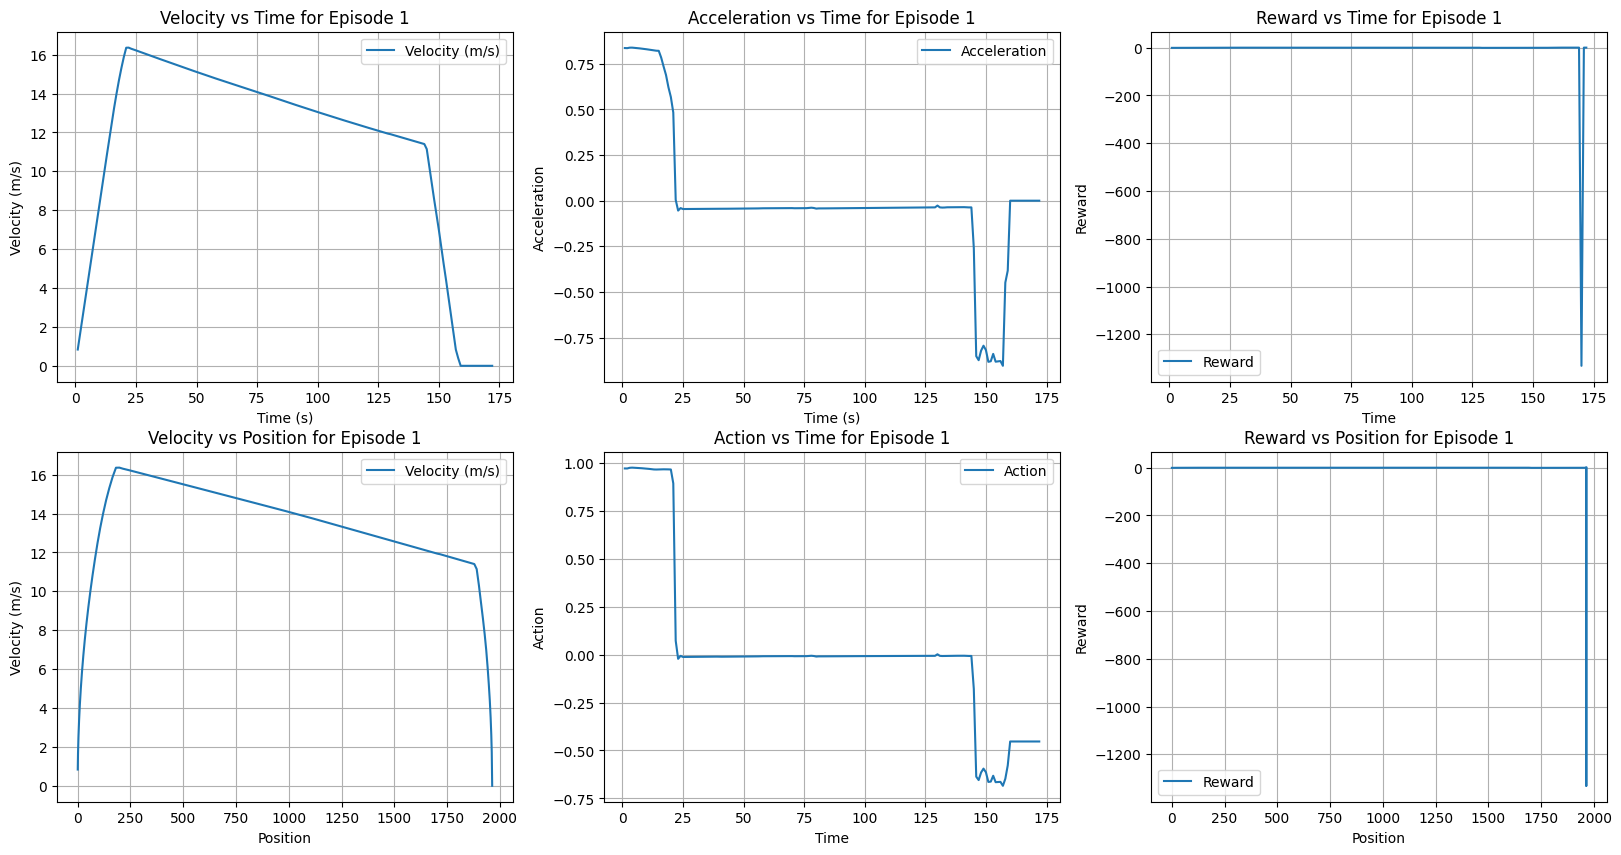

In [ ]:
    plt.figure(figsize=(20, 10))

    plt.subplot(2, 3, 1)
    plt.plot(time_data, velocity_data, label='Velocity (m/s)')
    plt.xlabel('Time (s)')
    plt.ylabel('Velocity (m/s)')
    plt.title('Velocity vs Time for Episode {}'.format(episode))
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 3, 2)
    plt.plot(time_data, acceleration_data, label='Acceleration')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration')
    plt.title('Acceleration vs Time for Episode {}'.format(episode))
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 3, 3)
    plt.plot(time_data, reward_data, label='Reward')
    plt.xlabel('Time')
    plt.ylabel('Reward')
    plt.title('Reward vs Time for Episode {}'.format(episode))
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 3, 4)
    plt.plot(position_data, velocity_data, label='Velocity (m/s)')
    plt.xlabel('Position')
    plt.ylabel('Velocity (m/s)')
    plt.title('Velocity vs Position for Episode {}'.format(episode))
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 3, 5)
    plt.plot(time_data, action_data, label='Action')
    plt.xlabel('Time')
    plt.ylabel('Action')
    plt.title('Action vs Time for Episode {}'.format(episode))
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 3, 6)
    plt.plot(position_data, reward_data, label='Reward')
    plt.xlabel('Position')
    plt.ylabel('Reward')
    plt.title('Reward vs Position for Episode {}'.format(episode))
    plt.legend()
    plt.grid(True)

    plt.show()

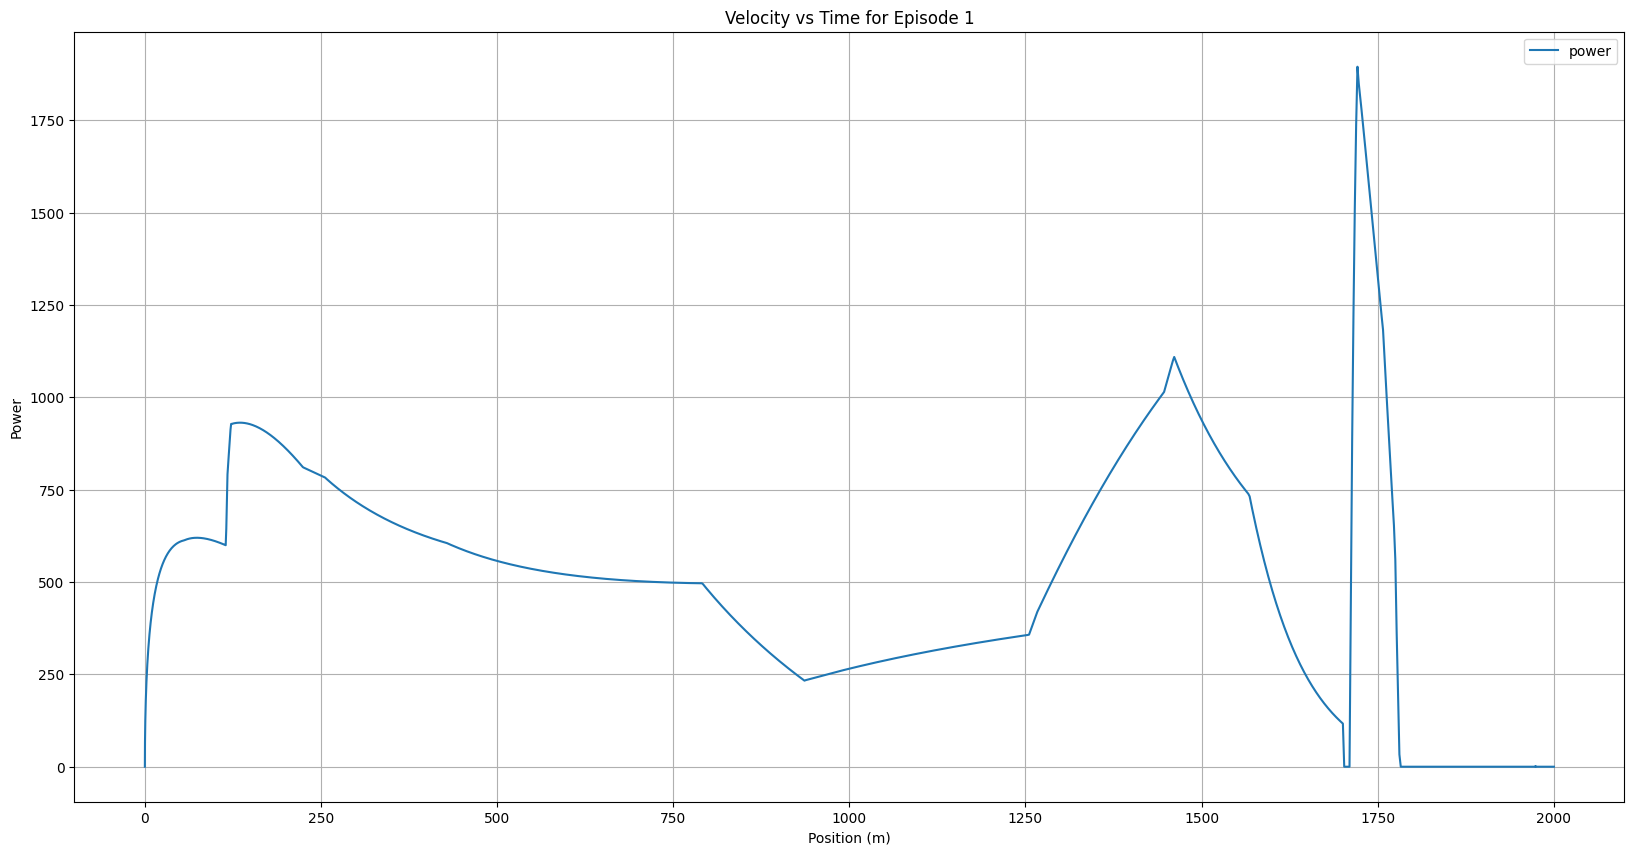

In [ ]:
    plt.figure(figsize=(20, 10))

    plt.plot(position_data, power_data, label='power')
    plt.xlabel('Position (m)')
    plt.ylabel('Power')
    plt.title('Velocity vs Time for Episode {}'.format(episode))
    plt.legend()
    plt.grid(True)


    plt.show()

# Other tests

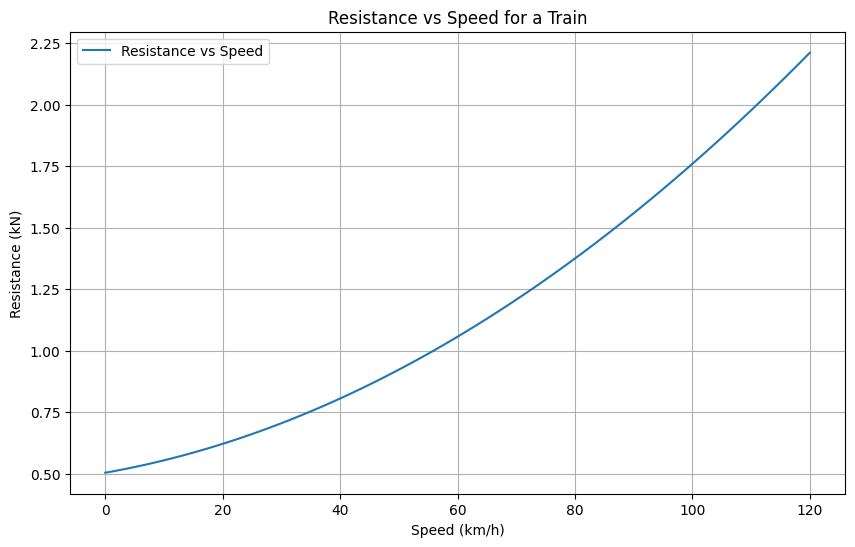

In [ ]:
    def Calc_Resistance(speed):
        """
        Calculate the basic resistance of a train running at a given speed.

        :param speed: Speed of the train in km/h
        :return: Basic resistance in kN
        """
        n = 24  # Number of axles
        N = 6  # Number of cars
        A = 10.64  # Cross-sectional area of the train in m^2
        # speed = self.velocity * 3.6  # Convert speed from m/s to km/h
        Mass = 300
        f_r = (6.4 * Mass + 130 * n + 0.14 * Mass * abs(speed) +
              (0.046 + 0.0065 * (N - 1)) * A * speed**2) / 1000
        f_r = 0.1 * f_r
        return f_r

speeds = np.linspace(0, 120, 121)
resistances = [Calc_Resistance(speed) for speed in speeds]

# Plotting the resistance vs speed
plt.figure(figsize=(10, 6))
plt.plot(speeds, resistances, label='Resistance vs Speed')
plt.xlabel('Speed (km/h)')
plt.ylabel('Resistance (kN)')
plt.title('Resistance vs Speed for a Train')
plt.grid(True)
plt.legend()
plt.show()

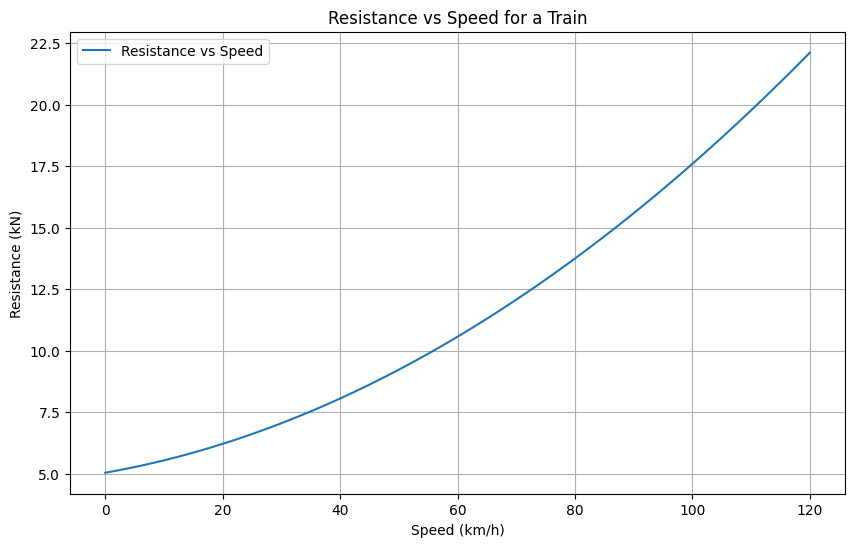

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Global variables
train_mass = 300  # Example mass of the train in Ton
n = 24  # Number of axles
N = 6  # Number of cars
A = 10.64  # Cross-sectional area of the train in m^2

def cal_resistance(speed):
    """
    Calculate the basic resistance of a train running at a given speed.

    :param speed: Speed of the train in km/h
    :return: Basic resistance in kN
    """
    f_r = (6.4 * train_mass + 130 * n + 0.14 * train_mass * speed +
           (0.046 + 0.0065 * (N - 1)) * A * speed**2) / 1000
    return f_r

# Speed range from 0 to 120 km/h
speeds = np.linspace(0, 120, 121)
resistances = [cal_resistance(speed) for speed in speeds]

# Plotting the resistance vs spee
plt.figure(figsize=(10, 6))
plt.plot(speeds, resistances, label='Resistance vs Speed')
plt.xlabel('Speed (km/h)')
plt.ylabel('Resistance (kN)')
plt.title('Resistance vs Speed for a Train')
plt.grid(True)
plt.legend()
plt.show()

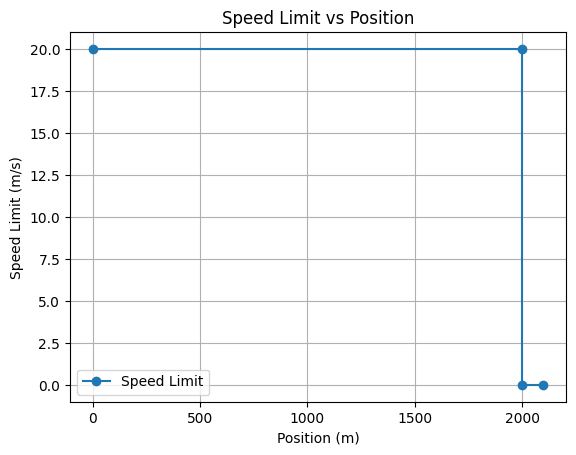

In [ ]:
import matplotlib.pyplot as plt

# Data for plotting
positions = [0, 2000, 2000, 2100]  # Position points along the track
speed_limits = [20, 20, 0, 0]  # Corresponding speed limits at those positions

# Create the figure and axis objects
fig, ax = plt.subplots()

# Plotting the data using step function for discrete changes
ax.step(positions, speed_limits, where='post', label='Speed Limit', marker='o', linestyle='-')

# Adding titles and labels
ax.set_title('Speed Limit vs Position')
ax.set_xlabel('Position (m)')
ax.set_ylabel('Speed Limit (m/s)')

# Adding a grid
ax.grid(True)

# Displaying the legend
ax.legend()

# Show the plot
plt.show()




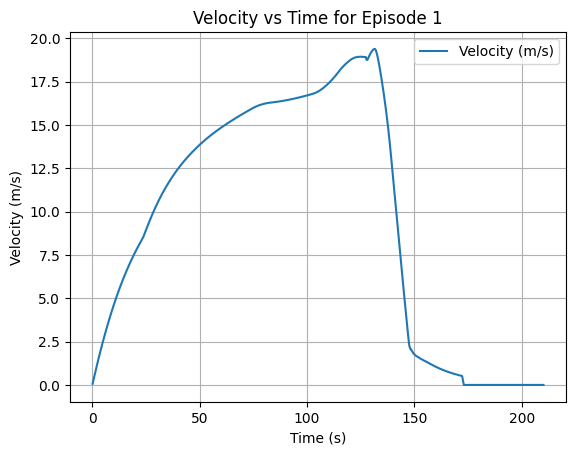

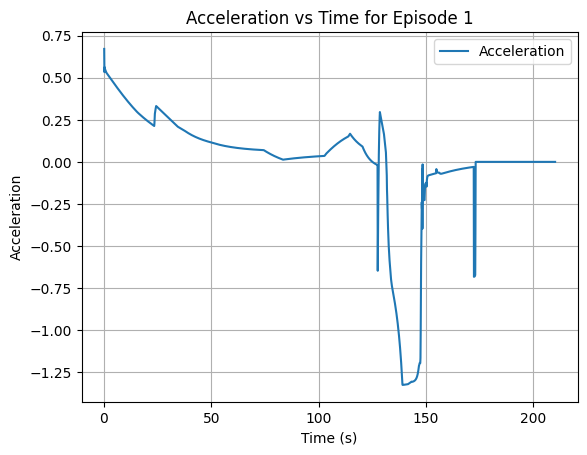

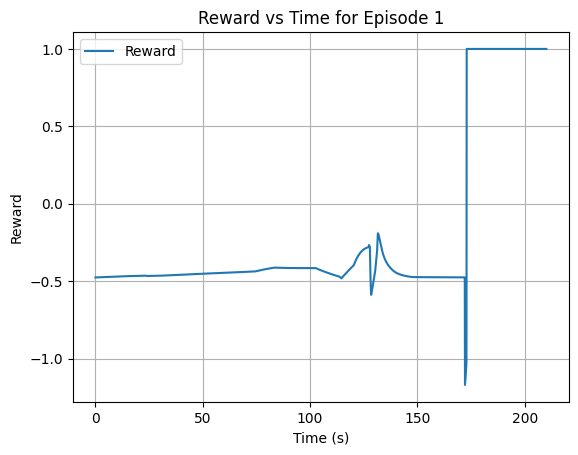

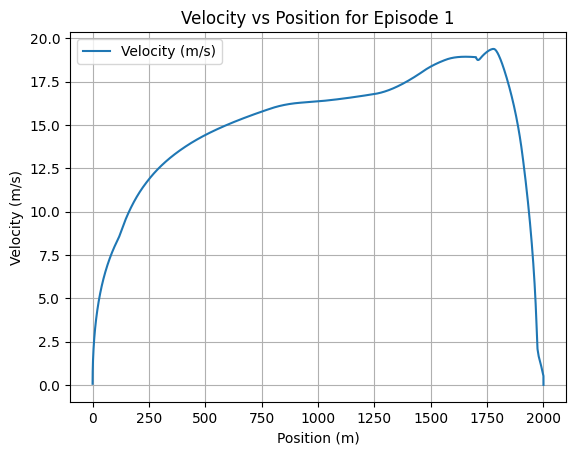

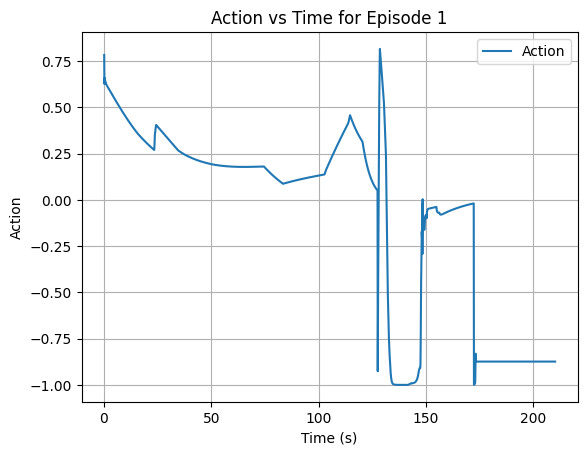

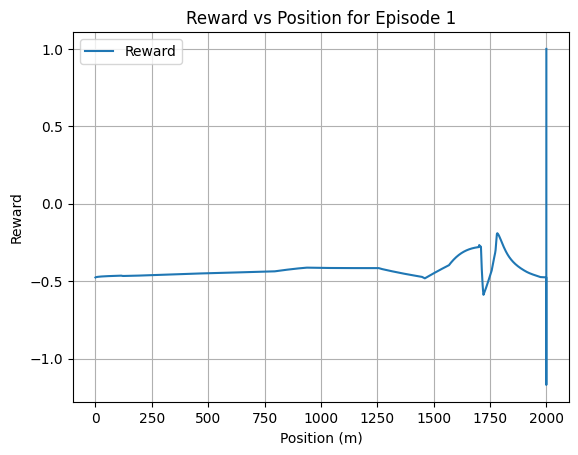

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'episode', 'time_data', 'velocity_data', 'acceleration_data', 'reward_data', 'position_data', 'action_data' are defined.

# Figure 1: Velocity vs Time
# plt.figure(figsize=(10, 7))
plt.plot(time_data, velocity_data, label='Velocity (m/s)')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity vs Time for Episode {}'.format(episode))
plt.legend()
plt.grid(True)
plt.show()

# Figure 2: Acceleration vs Time
# plt.figure(figsize=(10, 7))
plt.plot(time_data, acceleration_data, label='Acceleration')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration')
plt.title('Acceleration vs Time for Episode {}'.format(episode))
plt.legend()
plt.grid(True)
plt.show()

# Figure 3: Reward vs Time
# plt.figure(figsize=(10, 7))
plt.plot(time_data, reward_data, label='Reward')
plt.xlabel('Time (s)')
plt.ylabel('Reward')
plt.title('Reward vs Time for Episode {}'.format(episode))
plt.legend()
plt.grid(True)
plt.show()

# Figure 4: Velocity vs Position
# plt.figure(figsize=(10, 7))
plt.plot(position_data, velocity_data, label='Velocity (m/s)')
plt.xlabel('Position (m)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity vs Position for Episode {}'.format(episode))
plt.legend()
plt.grid(True)
plt.show()

# Figure 5: Action vs Time
# plt.figure(figsize=(10, 7))
plt.plot(time_data, action_data, label='Action')
plt.xlabel('Time (s)')
plt.ylabel('Action')
plt.title('Action vs Time for Episode {}'.format(episode))
plt.legend()
plt.grid(True)
plt.show()

# Figure 6: Reward vs Position
# plt.figure(figsize=(10, 7))
plt.plot(position_data, reward_data, label='Reward')
plt.xlabel('Position (m)')
plt.ylabel('Reward')
plt.title('Reward vs Position for Episode {}'.format(episode))
plt.legend()
plt.grid(True)
plt.show()
